In [1]:
#Imports
from transformers import BertConfig, BertForMaskedLM, BertModel, PreTrainedTokenizerFast, DataCollatorForLanguageModeling, BertPreTrainedModel
from transformers import Trainer, TrainingArguments

import random
import numpy as np
from packaging import version
import datasets
import torch.nn as nn
from tokenizers import Tokenizer
import torch
from tqdm import tqdm
from pathlib import Path
import wandb
import time
import os
from typing import Any, Optional, Tuple, Union
from collections import OrderedDict

from torch.nn import CrossEntropyLoss

from utils.LM_source_code import *
from utils.tokenizer_utils import *
import pickle

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#CHOOSE THE DATASET

#All options are: 1. Chopin43  
                # 2. Maestro
                # 3. Chopin and Hannds
        
        
dataset_choice = 'Chopin43'

In [3]:
dataset_map = {"Chopin43": '_C', 
               "ChopinAndHannds": '_CH',
               "Maestro": '_M'}
Key = dataset_map[dataset_choice]
handConfigNumsMap = {"Chopin43": 110, 
               "ChopinAndHannds": 136,
               "Maestro": 12047}


MDEDir = './Extracted_Repns/MDE' + Key

# Setting up MDE BERT
The MDE representation consists of 3 things for every note onset in a piece:
1. The pitch of the lowest note (a number 1-12 corresponding to A, A#, ....)
2. The octave of the lowest note (a number 0-7 corresponding to which octave on the piano)
3. The hand configuration (a number 0-136 that maps to a of hand configurations)

To feed this information into BERT with standard huggingface components, I am using an intermediate, proxy tokenizer. At each step, the three elements are concatenated with a separation character. For example, a step with pitch 6, octave 2, and hand configuration 12 becomes 6s2s12. With this intermediate step, the sequence is dimension (1, max_seq_len) instead of (3, max_seq_len), so the default huggingface tokenizers, collators, and trainers can be used.

Within the modified components, there are 3 separate embedding layers at the encoder and decoder(we effectively have three separate vocabularies). The first step in the encoder is to convert the MDE representation(ie. 6s2s12) back to a separate pitch, octave, hand representation so that it can be passed throgh three separate embedding layers.The outputs of the embedding layers can then be summed so that input to the attention layers has the normal shape (768). The decoder then has to have three separate linear layers to map the hidden state back to pitch, octave, hand.

In order to make these changes in huggingface, we need to construct a custom encoder by modifying the BertEmbedding layer, and a custom decoder by modifying the BertLMPredictionHead. We also need to modify the BertForMaskedLM model itself so that the forward function expects three outputs.



# Modified huggingface code

Here are the three elements that I modified from Huggingface. Modified elements are commented

Modified MaskedLM, the forward function is changed to calculate loss.

In [4]:
class BertForMaskedLM(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]

    def __init__(self, config):
        super().__init__(config)
        self.decoder = {value:key for key, value in config.decoder.items()}
        if config.is_decoder:
            logger.warning(
                "If you want to use `BertForMaskedLM` make sure `config.is_decoder=False` for "
                "bi-directional self-attention."
            )

        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    def get_output_embeddings(self):
        return self.cls.predictions.decoder

    def set_output_embeddings(self, new_embeddings):
        self.cls.predictions.decoder = new_embeddings


    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], MaskedLMOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the masked language modeling loss. Indices should be in `[-100, 0, ...,
            config.vocab_size]` (see `input_ids` docstring) Tokens with indices set to `-100` are ignored (masked), the
            loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`
        """

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        
        #The new decoder returns pitch, octave, and hand predictions
        pitch_p, octave_p, hand_p = self.cls(sequence_output)
        
        masked_lm_loss = None
        
        #For calculating loss, decode the labels from MDE representation (ex 5s3s31) into three sequences
        #of pitch, hand, octave
        if labels is not None:
            octaves = []
            pitches = []
            handConfs = []
            #Iterate through the batch
            for x in labels:
                #For each sequence, make a list to store the octave, pitch, and handConf ids
                octave = []
                pitch = []
                handConf = []
                #Iterate through the sequence
                for y in x:
                    #If the token is not a mask token, decode into the octave_pitch_handConf representation
                    if y.item() != -100:
                        #Split on s
                        code = [int(x) for x in self.decoder[y.item()].split('s')]
                        #Add each element to the correct list
                        octave.append(code[0])
                        pitch.append(code[1])
                        handConf.append(code[2])
                    else:
                        #Otherwise, make a representation from the mask token ie, -100, -100, -100
                        octave.append(y.item())
                        pitch.append(y.item())
                        handConf.append(y.item())
                #Aggregate the samples in the batch
                octaves.append(octave)
                pitches.append(pitch)
                handConfs.append(handConf)
            
            
            #Loss is still cross entropy
            loss_fct = CrossEntropyLoss()  # -100 index = padding token
            
            device = input_ids.device
            #Put the new labels on the gpu
            octaves = torch.LongTensor(octaves).to(device)
            pitches = torch.LongTensor(pitches).to(device)
            handConfs = torch.LongTensor(handConfs).to(device)
            
            #Calculate a loss for each
            octave_loss = loss_fct(octave_p.view(-1, octave_p.shape[2]), octaves.view(-1))
            pitch_loss = loss_fct(pitch_p.view(-1, pitch_p.shape[2]), pitches.view(-1))
            hand_loss = loss_fct(hand_p.view(-1, hand_p.shape[2]), handConfs.view(-1))
            
            #The returned loss is the sum of the three losses
            masked_lm_loss = octave_loss + pitch_loss + hand_loss
        if not return_dict:
            output = (prediction_scores,) + outputs[2:]
            return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output
        
        #This is where loss and predictions are returned
        #TODOs: The current model can't use the pipeline feature of transformers
        #since the pipeline expects logits to just be a tokenized MDE representation
        return MaskedLMOutput(
            loss=masked_lm_loss,
            logits=[pitch_p, octave_p, hand_p],
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
 
    def prepare_inputs_for_generation(self, input_ids, attention_mask=None, **model_kwargs):
        input_shape = input_ids.shape
        effective_batch_size = input_shape[0]

        #  add a dummy token
        if self.config.pad_token_id is None:
            raise ValueError("The PAD token should be defined for generation")

        attention_mask = torch.cat([attention_mask, attention_mask.new_zeros((attention_mask.shape[0], 1))], dim=-1)
        dummy_token = torch.full(
            (effective_batch_size, 1), self.config.pad_token_id, dtype=torch.long, device=input_ids.device
        )
        input_ids = torch.cat([input_ids, dummy_token], dim=1)

        return {"input_ids": input_ids, "attention_mask": attention_mask}

### Custom decoder

In [5]:
class CustomBertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        
        #Three separate linear layers for converting hidden state to outputs
        self.decode_pitch = nn.Linear(config.hidden_size, config.numPitches, bias=False)
        self.decode_octave = nn.Linear(config.hidden_size, config.numOctaves, bias=False)
        self.decode_hand = nn.Linear(config.hidden_size, config.numConfigs, bias=False)
        
        self.bias_p = nn.Parameter(torch.zeros(config.numPitches))
        self.bias_o = nn.Parameter(torch.zeros(config.numOctaves))
        self.bias_h = nn.Parameter(torch.zeros(config.numConfigs))


        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decode_pitch.bias = self.bias_p
        self.decode_octave.bias = self.bias_o
        self.decode_hand.bias = self.bias_h

    def forward(self, hidden_states):
        #Pass the hidden state through the three decoder layers
        hidden_states = self.transform(hidden_states)
        pitch = self.decode_pitch(hidden_states)
        octave = self.decode_octave(hidden_states)
        hand = self.decode_hand(hidden_states)
        return pitch, octave, hand

### Custom encoder

In [6]:
class CustomBertEmbeddings(nn.Module):
    """Construct the embeddings from octave, pitch, hand configuration, and position."""

    def __init__(self, config):
        super().__init__()
        #Get the mapping from token to encoded representation
        self.decoder = {value:key for key, value in config.decoder.items()}
        
        #Aggregate special tokens
        self.maskToken = config.decoder['[MASK]']
        self.unkToken = config.decoder['[UNK]']
        self.sepToken = config.decoder['[SEP]']
        self.padToken = config.decoder['[PAD]']
        self.clsToken = config.decoder['[CLS]']
        self.specialTokens = [self.maskToken, self.unkToken, self.sepToken, self.padToken, self.clsToken]
        
        #Declare embedding layers
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.pitch_embeddings = nn.Embedding(config.numPitches, config.hidden_size)
        self.handConfig_embeddings = nn.Embedding(config.numConfigs, config.hidden_size)
        self.octave_embeddings = nn.Embedding(config.numOctaves, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        if version.parse(torch.__version__) > version.parse("1.6.0"):
            self.register_buffer(
                "token_type_ids",
                torch.zeros(self.position_ids.size(), dtype=torch.long),
                persistent=False,
            )

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        #Custom code to use 3 embedding layers
        #Convert the tokenized MDE representation ie 9s2s55 to pitch=9 octave=2 hand=55 for all tokens in the batch
        octaves = []
        pitches = []
        handConfs = []
        #Iterate through the batch
        for x in input_ids:
            #For each sequence, make a list to store the octave, pitch, and handConf ids
            octave = []
            pitch = []
            handConf = []
            #Iterate through the sequence
            for y in x:
                #If the token is not a special token, decode into the octave_pitch_handConf representation
                if y.item() not in self.specialTokens:
                    #Split on s
                    try:
                        code = [int(x) for x in self.decoder[y.item()].split('s')]
                    except:
                        code = [x for x in self.decoder[y.item()].split('s')]
                        print(code)
                    #Add each element to the correct list
                    octave.append(code[0])
                    pitch.append(code[1])
                    handConf.append(code[2])
                else:
                    #Otherwise, make a representation from the special token. ie: a cls token(1) becomes 1_1_1
                    octave.append(y.item())
                    pitch.append(y.item())
                    handConf.append(y.item())
            #Aggregate the samples in the batch
            octaves.append(octave)
            pitches.append(pitch)
            handConfs.append(handConf)
            
        device = input_ids.device if input_ids is not None else inputs_embeds.device
        
        #Convert the lists to tensors and put them on the gpu
        octTensor = torch.LongTensor(octaves).to(device)
        pitchTensor = torch.LongTensor(pitches).to(device)
        handConfTensor = torch.LongTensor(handConfs).to(device)
        
        #Sum the three embeddings
        input_embeds = self.handConfig_embeddings(handConfTensor)\
                       +self.octave_embeddings(octTensor)\
                       +self.pitch_embeddings(pitchTensor)
        embeddings = input_embeds

        #Standard BertEmbeddings code
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        
        if position_ids is None:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(input_shape)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

### Custom Configuration

In order for the encoder and MaskedLM to access the dictionary between MDE representation and tokens, we need to pass that in the model's config

# THIS MUST BE CHANGED FOR DIFFERENT DATASETS. THE numCONFIGS COMES FROM CREATING THE HANDCONIG DICTIONARY

In [7]:
class CustomBertConfig(BertConfig):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        #The decoder holds the conversion back to the coded representation for the customEmbeddings layer
        self.decoder = kwargs.get('decoder')
        self.numOctaves = 9
        self.numConfigs = handConfigNumsMap[dataset_choice]
        self.numPitches = 12

# Setup the Tokenizer and paths

In [8]:
#login to wandb for logging
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mconati (use `wandb login --relogin` to force relogin)


True

In [9]:
#Setup paths
TOKENIZER_SAVEDIR = Path(MDEDir + '/tokenizer')
LM_MODEL_SAVEDIR = Path(MDEDir + '/model')
Path(LM_MODEL_SAVEDIR).mkdir(exist_ok=True)

PRIMUS_TXT_FILES = Path(MDEDir + '/text')
TXT_LOCATION = Path(MDEDir + '/full')
files = [str(TXT_LOCATION / path) for path in os.listdir(TXT_LOCATION)]

In [10]:
#Verify a GPU is enabled

print('Cuda available: ', torch.cuda.is_available())
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

Cuda available:  True


[<torch.cuda.device at 0x7f26850b2190>, <torch.cuda.device at 0x7f2686216b90>]

In [11]:
import numpy as np
import matplotlib.pyplot as plt


#Create a vocab for the dictionary of tokens that appear at least (threshold) times
def makeVocab(MDEDir, threshold = 2):
    tpath = MDEDir + '/full/MDE.txt'
    my_file = open(tpath, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data = np.array(data.replace('\n', '').split(" "))[:-1]
    print(data)

    u,counts = np.unique(data, return_counts=True)
    pairs = sorted(zip(counts,u), reverse=True)
    counts, u = zip(*pairs)
    
    plt.plot(sorted(counts, reverse=True))
    plt.title("Vocab")
    plt.ylabel("Frequency")
    plt.xlabel("Token number")
    
    threshold = threshold
    for idx, c in enumerate(counts):
        if c < threshold:
            break
    vocab_size = idx

    vocab = {}
    vocab['[UNK]'] = 0
    vocab['[CLS]'] = 1
    vocab['[SEP]'] = 2
    vocab['[PAD]'] = 3
    vocab['[MASK]'] = 4
    token_offset = 5
    for i,qanon in enumerate(u):
        if i > vocab_size:
            break
        vocab[qanon] = token_offset + i 
    return vocab

['3s4s1' '2s6s1' '3s4s1' ... '3s2s3' '3s2s3' '1s2s20']


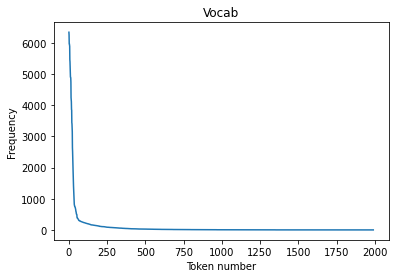

In [12]:
#Create the vocab and make a custom tokenizer from it
vocab = makeVocab(MDEDir, 2)
tokenizer = BertTokenizer(vocab)

#Save the tokenizer
tokenizer_dir = TOKENIZER_SAVEDIR
tokenizer.save_pretrained(tokenizer_dir)
with open(f'{tokenizer_dir}/vocab.pkl','wb') as f:
    pickle.dump(vocab,f)

#Visualization of the vocab. Many tokens are very uncommon, the vocab threshold
#can be adjusted as desired to remove uncommon tokens from the dictionary

# Setup the model

In [13]:
config = CustomBertConfig(
    #The decoder holds the conversion back to the coded representation for the customEmbeddings layer
    decoder = tokenizer.vocab,
    vocab_size=len(vocab),
)

len(vocab)

1605

In [14]:
#Create a standard BERT model
model = BertForMaskedLM(config=config)
device = model.device
print('Original Num parameters:', model.num_parameters())


#Create a custom embedding class
temp = CustomBertEmbeddings(config).to(device)
#Replace the model's embedding layer
model.bert.embeddings = temp

#create a custom decoder
temp = CustomBertLMPredictionHead(config).to(device)
#replace the custom decoder
model.cls.predictions = temp
model = model.to(device)


print('New Num parameters:', model.num_parameters())
print()

#As a sanity check, make sure that the custom embedding layers exist
print("Shape of the hand configurations embedding layer:")
print(model.bert.embeddings.handConfig_embeddings.weight.shape)

Original Num parameters: 87277125
New Num parameters: 86242691

Shape of the hand configurations embedding layer:
torch.Size([110, 768])


# Setup the dataset

In [15]:
#Define parameters of the training

MAX_LEN = 128 #max length of training sequences
MASKING_PROPORTION = 0.15 #masking proportion for MLM training
NUM_EPOCHS = 5000
BATCH_SIZE = 160


In [16]:
from torch.utils.data import Dataset

#Custom dataset for the MLM task. Creates sequences of length max_length from the text files
#, and pads as needed
class CustomDataset(Dataset):
    def __init__(self, src_files, tokenizer, max_length=64):
        self.examples = []
        for src_file in tqdm.tqdm(src_files):
            words = src_file.read_text(encoding="utf-8").split()
            words = np.array(words[:len(words) - len(words) % max_length])
            chunks = words.reshape(-1, max_length)
            for example in chunks:
                sentence = " ".join(example)
                self.examples += [sentence]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

In [17]:
#Splits the Custom Dataset into train and test sets
import random
def create_train_test_datasets(tokenizer, max_length, fraction=1.0, test_size=0.1, valTest = False):
    src_files = list(Path(PRIMUS_TXT_FILES).glob("**/*.txt"))
    src_files = src_files[:int(len(src_files) * fraction)]
    
    print("Number of source files:")
    print(len(src_files))
    
    sentences = CustomDataset(src_files, tokenizer, max_length=max_length).examples
    random.shuffle(sentences)
    
    #Make a train, valid, and a test split
    if valTest:
        train_split = 1-(2*test_size)
        train_sentences = sentences[:int(len(sentences)*train_split)]
        test_sentences = sentences[int(len(sentences)*train_split):int(len(sentences)*(1-test_size))]
        valid_sentences = sentences[int(len(sentences)*(1-test_size)):]
        train_inputs = tokenizer(train_sentences, return_tensors='pt',max_length=max_length,truncation=True, padding='max_length')
        test_inputs = tokenizer(test_sentences, return_tensors='pt',max_length=max_length,truncation=True, padding='max_length')
        valid_inputs = tokenizer(valid_sentences, return_tensors='pt',max_length=max_length,truncation=True, padding='max_length')
        train_inputs['labels'] = train_inputs.input_ids.detach().clone()
        test_inputs['labels'] = test_inputs.input_ids.detach().clone()
        valid_inputs['labels'] = valid_inputs.input_ids.detach().clone()
        train_dataset = datasets.Dataset.from_dict(train_inputs)
        test_dataset = datasets.Dataset.from_dict(test_inputs)
        valid_dataset = datasets.Dataset.from_dict(valid_inputs)
        
        return train_dataset, valid_dataset, test_dataset
    
    #Only make a train/valid split
    train_split = 1-test_size
    train_sentences = sentences[:int(len(sentences)*train_split)]
    test_sentences = sentences[int(len(sentences)*train_split):]
    train_inputs = tokenizer(train_sentences, return_tensors='pt',max_length=max_length,truncation=True, padding='max_length')
    test_inputs = tokenizer(test_sentences, return_tensors='pt',max_length=max_length,truncation=True, padding='max_length')
    train_inputs['labels'] = train_inputs.input_ids.detach().clone()
    test_inputs['labels'] = test_inputs.input_ids.detach().clone()
    train_dataset = datasets.Dataset.from_dict(train_inputs)
    test_dataset = datasets.Dataset.from_dict(test_inputs)
    
    
    return train_dataset, test_dataset

In [18]:
train_dataset, valid_dataset, test_dataset = create_train_test_datasets(tokenizer, MAX_LEN, fraction=1.0, test_size=0.1, valTest=True)

Number of source files:
301


100%|████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 3646.00it/s]


# Huggingface Training code

In [19]:
#BERT training code basically copied from the Huggingface Esperanto Tutorial from here on out
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=MASKING_PROPORTION
)

In [20]:
training_args = TrainingArguments(
    output_dir=LM_MODEL_SAVEDIR,
    overwrite_output_dir=True,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    save_steps=100,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=1,
    prediction_loss_only=False,
    report_to="wandb",
    load_best_model_at_end = True
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)
trainer.args

TrainingArguments(
_n_gpu=2,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=100,
evaluation_strategy=IntervalStrategy.STEPS,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=True,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=Extracted_Repns/MDE_C

In [ ]:
trainer.train()

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1120
  Num Epochs = 5000
  Instantaneous batch size per device = 160
  Total train batch size (w. parallel, distributed & accumulation) = 320
  Gradient Accumulation steps = 1
  Total optimization steps = 20000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
100,4.495200,4.163774
200,4.005400,4.026281
300,3.841800,3.911815
400,3.606000,3.604095
500,3.330200,3.370882
600,3.096400,3.193584
700,2.803500,2.883422
800,2.524700,2.678756
900,2.289000,2.416692
1000,2.073100,2.314526


***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-100
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-100/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-100/pytorch_model.bin
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-200
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-200/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-100] due to args.save_tota

***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-1300
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-1300/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-1200] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-1400
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-1400/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-1400/pyt

***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-2500
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-2500/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-2500/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-2300] due to args.save_total_limit
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-2400] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-2600
Configuration saved in Extracted_Repns/MDE_C/mod

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-3700
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-3700/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-3700/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-3400] due to args.save_total_limit
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-3600] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scal

***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-4800
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-4800/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-4800/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-4700] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-4900
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-4900/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-4900/pyt

***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-6000
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-6000/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-6000/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-5900] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-6100
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-6100/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-6100/pyt

/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-7200
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-7200/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-7200/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-6600] due to args.save_total_limit
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-7100] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scal

Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-8300/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-8300/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-8200] due to args.save_total_limit
/home/mconati/ttmp/anaconda3/envs/jukebox/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 140
  Batch size = 16
Saving model checkpoint to Extracted_Repns/MDE_C/model/checkpoint-8400
Configuration saved in Extracted_Repns/MDE_C/model/checkpoint-8400/config.json
Model weights saved in Extracted_Repns/MDE_C/model/checkpoint-8400/pytorch_model.bin
Deleting older checkpoint [Extracted_Repns/MDE_C/model/checkpoint-8300] due to args.save_total_limit
/home/mconati/ttmp/anacon

In [ ]:
BEST_MODEL_SAVEDIR = Path(MDEDir + '/best')
trainer.save_model(BEST_MODEL_SAVEDIR)

# Testing the model and performance

In [ ]:
loadModel = True
mpath = MDEDir + '/best/model/pytorch_model.bin'

In [ ]:
if loadModel:
    #Load a pretrained BERT model
    model = BertForMaskedLM(config=config)
    print('Num parameters:', model.num_parameters())


    #Create a custom embedding class
    temp = CustomBertEmbeddings(config)
    #Replace the model's embedding layer
    model.bert.embeddings = temp

    temp = CustomBertLMPredictionHead(config)
    model.cls.predictions = temp

    mdict = torch.load(mpath)

    model.load_state_dict(mdict)

### The following functions convert samples in the test set to sequences, and provide funtionality for getting model outputs on those samples. They also allow for quantifying accuracy of the model predictions(how often the model predicts exactly right)

In [ ]:
#Converts a dataset sample to a string that the model can perform inference on
#Randomly adds masking tokens with the given probability

def samp2seq(n, dataset, tokenizer, start = 0, stop = -1, maskProb = 0):
    samp = dataset[n]["input_ids"][start:stop]

    a = np.array(samp)
    decoder = {value:key for key, value in tokenizer.vocab.items()}
    b = [decoder[x] for x in a]
    seq = ""
    for idx, x in enumerate(b):
        rand = random.random()
        if rand < maskProb and x!='[CLS]' and x!='[SEP]':
            x = "[MASK]"
        if idx == 0:
            seq = seq + str(x)
        else:
            seq = seq + " " + str(x)
        if idx == len(b)-1:
            seq = seq + " " + "[SEP]"
    return seq

In [ ]:
#Converts a string to tokens with the given tokenizer, and finds model predictions on it

def modelPred(seq, model, tokenizer):
    device = model.device
    tokenized = torch.Tensor(tokenizer(seq)["input_ids"]).to(device)
    tokenized = tokenized[1:-1].view(1, -1) #get rid of extra CLS and SEP tokens
    preds = model(tokenized)['logits']
    pitches = torch.argmax(preds[0], axis=2).detach().cpu().numpy().squeeze()
    octaves = torch.argmax(preds[1], axis=2).detach().cpu().numpy().squeeze()
    handConfs = torch.argmax(preds[2], axis=2).detach().cpu().numpy().squeeze()
    numTokens = len(pitches)
    
    seq = ""
    for idx, x in enumerate(octaves):
        octave = octaves[idx]
        pitch = pitches[idx]
        hand = handConfs[idx]
        MDE = str(octave)+ "s" + str(pitch)+ "s" + str(hand)
        if idx>0 and idx<numTokens-2:
            seq = seq + MDE + " "
        if idx ==numTokens-2:
            seq = seq + MDE
    
    return seq
    

Generate test sequences

In [ ]:
original = samp2seq(0, test_dataset, tokenizer, 0, 50)
masked = samp2seq(0, test_dataset, tokenizer, 0, 50, maskProb=0.15)
original

In [ ]:
masked

In [ ]:
pred = modelPred(original, model, tokenizer)
pred

Evaluate accuracy on a prediction (What percentage of masked tokens are predicted exactly right)

In [ ]:
def evaluateAcc(original, masked, pred):
    pred = '[CLS] ' + pred + ' [SEP]'
    original = original.split(' ')
    masked = masked.split(' ')
    pred = pred.split(' ')
    
    total = 0
    octave = 0
    pitch = 0
    hand = 0

    for x, item in enumerate(masked):
        if item == '[MASK]' and original[x] !='[PAD]':
            actual = original[x].split('s')
            predicted = pred[x].split('s')
            total +=1
            

            try:
                if actual[0]==predicted[0]:
                    octave +=1
                if actual[1]==predicted[1]:
                    pitch +=1
                if actual[2]==predicted[2]:
                    hand +=1
            except:
                #This is an unk tooooken
                pass
                
    if total > 0:
        octaveAcc = octave/total
        pitchAcc = pitch/total
        handAcc = hand/total
    else:
        #NO MASKING OCCURRED!
        return -1, -1, -1
                

    
    return octaveAcc, pitchAcc, handAcc

Make predictions on samples from an entire dataset (test set recommended), and return accuracy

In [ ]:
def checkOverWholeSet(maskProb, train_dataset, tokenizer, model):
    o_total = 0
    p_total = 0
    h_total = 0
    total = 0
    for sampleNum, x in enumerate(tqdm.tqdm(range(len(train_dataset)))):
        original = samp2seq(sampleNum, train_dataset, tokenizer)
        masked = samp2seq(sampleNum, train_dataset, tokenizer, maskProb=maskProb)
        pred = modelPred(masked, model, tokenizer)

        o, p, h = evaluateAcc(original, masked, pred)
        if o == -1:
            continue
        o_total +=o
        p_total +=p
        h_total +=h
        total +=1
    if total != 0:
        o_acc = o_total/total
        p_acc = p_total/total
        h_acc = h_total/total
        return o_acc, p_acc, h_acc
    return 1,1,1

For fun, vary the masking proportion and plot accuracies over the entire test set

In [ ]:
import matplotlib.pyplot as plt

def varyMaskAndPlot(maskProbs, test_dataset, tokenizer, model):
    o_accs = []
    p_accs = []
    h_accs = []
    for maskProb in maskProbs:
        print("CHECKING MASKPROB: " + str(maskProb))
        o_acc, p_acc, h_acc = checkOverWholeSet(maskProb, test_dataset, tokenizer, model)
        o_accs.append(o_acc)
        p_accs.append(p_acc)
        h_accs.append(h_acc)
    
    plt.plot(maskProbs, o_accs, 'g', label='Octave Accuracy')
    plt.plot(maskProbs, p_accs, 'b', label='Pitch Accuracy')
    plt.plot(maskProbs, h_accs, 'r', label='Hand Configuration Accuracy')


    plt.title('Masking Percentage and Prediction Accuracy on Masked Tokens')

    plt.xlabel('Masking Percentage')

    plt.ylabel('Prediction Accuracy on Masked Tokens')

    plt.legend()

    plt.show()
    

Check the accuracies on one sequence from a dataset

In [ ]:
sampleNum = 1
maskProb = 0.1

original = samp2seq(sampleNum, test_dataset, tokenizer)
masked = samp2seq(sampleNum, test_dataset, tokenizer, maskProb=maskProb)
pred = modelPred(masked, model, tokenizer)

accuracies = evaluateAcc(original, masked, pred)
print("Octave Accuracy: {}".format(accuracies[0]))
print("Pitch Accuracy: {}".format(accuracies[1]))
print("Hand Configuration Accuracy: {}".format(accuracies[2]))

Check the average accuracy on all sequences in a dataset

In [ ]:
maskProb = 0.1
checkOverWholeSet(maskProb, test_dataset, tokenizer, model)

Check for many different masking probabilities and plot

In [ ]:
maskProbs = np.arange(20)/20
varyMaskAndPlot(maskProbs, test_dataset, tokenizer, model)